# Gradient-free Global Maximum Likelihood Finding: Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances, and symmetries in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS uses slice sampling as a gradient-free way to sample from hard-likelihood constraints, starting from small likelihoods and strictly increasing towards a maximum likelihood. This actually means that JAXNS is performing global maximisation of the likelihood. The prior can be seen as a measure which guides where JAXNS looks first. An attractive idea is to think about the prior as a guide for efficient global maximisation with JAXNS, but that's for another tutorial ;).

## Overview

In this tutorial we'll cover:
1. How to build a JAXNS model of a neural network using [Haiku](https://github.com/deepmind/dm-haiku)
2. How to do global likelihood maximisation with JAXNS

In [1]:
try:
    import haiku as hk
except ImportError:
    raise ImportError("You must `pip install dm-haiku` first.")

try:
    from sklearn.metrics import roc_curve
except:
    raise ImportError("You must `pip install scikit-learn`")

from jax import numpy as jnp, random, vmap
import jax
from jax.flatten_util import ravel_pytree

from jaxns.prior_transforms import UniformPrior, PriorChain
from jaxns import NestedSampler
from jaxns.plotting import plot_diagnostics
from jaxns.utils import summary
from jax.scipy.optimize import minimize
from itertools import product
import pylab as plt

# for parallel sampling
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"



In [2]:
# Generate data

def xor_reduce(x):
    """
    Computes the XOR reduction on a sequence of bits.

    Examples:
        100 -> xor(xor(1,0),0) = 1
        001 -> xor(xor(0,0),1) = 1
        110 -> xor(xor(1,1),0) = 0
        011 -> xor(xor(0,1),1) = 0

    Args:
        x: boolean vector of bits.

    Returns:
        bool, scalar
    """
    output = x[0]
    for i in range(1, x.shape[-1]):
        output = jnp.logical_xor(output, x[i])
    return output


num_variables = 8
options = [True, False]
x = jnp.asarray(list(product(options, repeat=num_variables)))#N,2
y = vmap(xor_reduce)(x)[:, None]#N, 1
x = x.astype(jnp.float32)
print("Data:")

for input, output in zip(x,y):
    print(f"{input} -> {output}")


INFO[2022-03-27 22:44:59,636]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-03-27 22:44:59,637]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-03-27 22:44:59,638]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-03-27 22:44:59,638]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Data:
[1. 1. 1. 1. 1. 1. 1. 1.] -> [False]
[1. 1. 1. 1. 1. 1. 1. 0.] -> [ True]
[1. 1. 1. 1. 1. 1. 0. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 0. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 0. 1. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 0. 1.] -> [False]
[1. 1. 1. 1. 1. 0. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1. 1.] -> [ True]
[1. 1. 1. 1. 0. 1. 1. 0.] -> [False]
[1. 1. 1. 1. 0. 1. 0. 1.] -> [False]
[1. 1. 1. 1. 0. 1. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 1. 1.] -> [False]
[1. 1. 1. 1. 0. 0. 1. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 0. 1.] -> [ True]
[1. 1. 1. 1. 0. 0. 0. 0.] -> [False]
[1. 1. 1. 0. 1. 1. 1. 1.] -> [ True]
[1. 1. 1. 0. 1. 1. 1. 0.] -> [False]
[1. 1. 1. 0. 1. 1. 0. 1.] -> [False]
[1. 1. 1. 0. 1. 1. 0. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 1. 1.] -> [False]
[1. 1. 1. 0. 1. 0. 1. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 0. 1.] -> [ True]
[1. 1. 1. 0. 1. 0. 0. 0.] -> [False]
[1. 1. 1. 0. 0. 1. 1. 1.] -> [False]
[1. 1. 1. 0. 0. 1. 1. 0.] -> [ True]
[1. 1. 1. 0. 0. 1. 0. 1.] -> [ T

In [3]:
# Define the likelihood, using Haiku as our framework for neural networks

def model(x, is_training=False):
    mlp0 = hk.Sequential([hk.Linear(3)])

    mlp1 = hk.Sequential([hk.Linear(3),
                         jax.nn.sigmoid])

    mlp2 = hk.Sequential([hk.Linear(1)])
    x = mlp0(x)#project to 2
    x = mlp1(x) + x
    x = mlp1(x) + x
    x = mlp1(x) + x
    x = mlp1(x) + x
    x = mlp2(x)#project to 1
    return x

model = hk.without_apply_rng(hk.transform(model))
# We must call the model once to get the params shape and type as a big pytree
# We then use ravel_pytree to flatten and get the unflatten function.
init_params = model.init(random.PRNGKey(2345), x)
init_params_flat, unravel_func = ravel_pytree(init_params)
n_dims = init_params_flat.size
print("Number of parameters:", n_dims)

def softplus(x):
    return jnp.log1p(jnp.exp(x))

def log_likelihood(params, **kwargs):
    """
    log(P(y|p))
    p = exp(logits)/1 - exp(logits)
    = log(p) * y + log(1-p) * (1-y)
    = logits * y1 - log(exp(-logits)/(exp(-logits) - 1)) * y0
    """
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    log_prob0, log_prob1 = -softplus(logits), -softplus(-logits)
    #log(p) * y + log(1-p) * (1-y)
    log_prob = jnp.mean(jnp.where(y, log_prob1, log_prob0))
    return jnp.asarray(log_prob, jnp.float64)


Number of parameters: 43


In [4]:
# Let us compare the results of nested sampling to optimisation done with BFGS
num_random_init = 100
init_keys = random.split(random.PRNGKey(42), num_random_init)
params_bfgs = vmap(lambda key: minimize(lambda p: -log_likelihood(p),
                   random.normal(key, shape=(n_dims,)),
                   method='BFGS').x)(init_keys)
log_L_bfgs = vmap(log_likelihood)(params_bfgs)
idx_max = jnp.argmax(log_L_bfgs)
log_L_bfgs_max = log_L_bfgs[idx_max]
params_bfgs_max = params_bfgs[idx_max]
print(f"BFGS maximum likelihood solution of {num_random_init} tries: log(L) = {log_L_bfgs_max}")

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda

BFGS maximum likelihood solution of 100 tries: log(L) = -0.0013167073484510183


/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


In [5]:
# Build the model

with PriorChain() as prior_chain:
    # we'll effectively place no prior on the parameters, other than requiring them to be within [-10,10]
    UniformPrior('params', -10.*jnp.ones(n_dims), 10.*jnp.ones(n_dims))

# We'll do some strange things here.
# num_slices -> low: We'll make the sampler do very few slices. This will lead to large correlation between samples, and poor estimate of the evidence.
# This is alright, because we'll be looking for the maximum likelihood solution.
ns = NestedSampler(loglikelihood=log_likelihood, prior_chain=prior_chain,
                   num_parallel_samplers=4,
                   sampler_kwargs=dict(gradient_boost=True))


/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3662: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
WARNING[2022-03-27 22:47:32,969]: Increasing max_samples (100000) by 3200 to evenly divide samples_per_step


In [6]:
# Let's test the model with a small sanity check.
prior_chain.test_prior(random.PRNGKey(42), 10, log_likelihood)

WARNING[2022-03-27 22:47:32,983]: Function log_likelihood has **varkw parameter (kwargs), and is being dropped.
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
INFO[2022-03-27 22:47:33,814]: Log-likelihood: -inf
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X6

In [7]:
# We do another strange thing here: we set the number of live points really low, which is okay because we don't care about evidence (yet)
# ns = jit(ns, static_argnames='maximise_likelihood')
results = ns(random.PRNGKey(42),
                  termination_max_num_steps=60,
                maximise_likelihood=True)

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3662: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
WARNING[2022-03-27 22:47:34,15

In [8]:
# The maximum likelihood solution from nested sampling
params_max = results.sample_L_max['params']
log_L_max = results.log_L_max
print("log L_max(L)", log_L_max)

log L_max(L) -0.59130156


--------
Termination Conditions:
Reached max samples
--------
# likelihood evals: 82510709
# samples: 103200
# likelihood evals / sample: 799.5
--------
logZ=-6.75 +- 0.016
H=58.0
ESS=5644
--------
params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
params[0]: -0.2 +- 5.8 | -8.1 / -0.4 / 7.9 | -4.1 | 2.6
params[1]: -0.3 +- 5.6 | -8.0 / -0.3 / 7.4 | 6.5 | -0.1
params[2]: -0.4 +- 5.7 | -8.2 / -0.7 / 7.7 | 2.0 | 2.5
params[3]: 0.1 +- 5.5 | -7.6 / 0.2 / 7.7 | -3.6 | -3.8
params[4]: 0.1 +- 5.6 | -7.7 / 0.2 / 7.8 | 8.6 | -8.9
params[5]: -0.2 +- 5.7 | -8.0 / -0.6 / 7.8 | 9.7 | -1.9
params[6]: 0.3 +- 5.7 | -7.7 / 0.4 / 7.9 | -0.7 | -4.0
params[7]: 0.0 +- 5.7 | -8.0 / 0.1 / 7.9 | -5.9 | 1.1
params[8]: -0.0 +- 5.6 | -7.8 / -0.1 / 7.6 | 7.2 | -4.9
params[9]: -0.0 +- 5.6 | -7.8 / 0.0 / 7.8 | 0.0 | -8.8
params[10]: -0.0 +- 5.7 | -7.8 / 0.0 / 7.8 | 5.8 | -1.5
params[11]: 0.0 +- 5.5 | -7.6 / -0.0 / 7.8 | -6.7 | -9.2
params[12]: -0.2 +- 5.5 | -7.7 / -0.2 / 7.6 | -5.9 | 2.1


WARNING[2022-03-27 22:54:57,518]: No handles with labels found to put in legend.


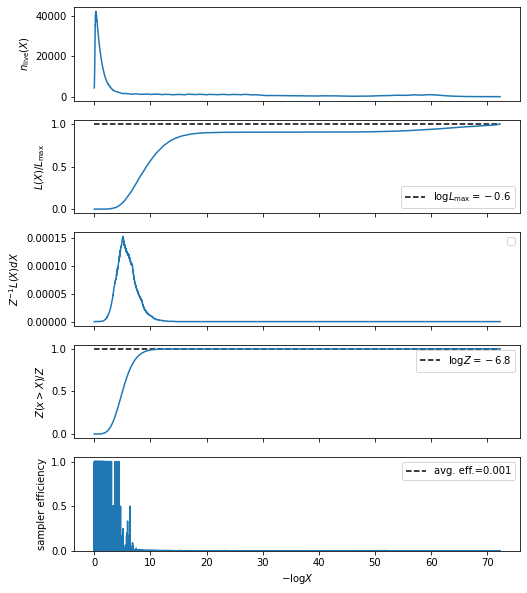

In [9]:
summary(results)
plot_diagnostics(results)

In [10]:

def predict(params):
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    return jax.nn.sigmoid(logits)[:,0]



Predictions of globally optimised NN:
0: [1. 1. 1. 1. 1. 1. 1. 1.] -> [False] | pred: 0.6487628817558289
1: [1. 1. 1. 1. 1. 1. 1. 0.] -> [ True] | pred: 0.7931578755378723
2: [1. 1. 1. 1. 1. 1. 0. 1.] -> [ True] | pred: 0.35116735100746155
3: [1. 1. 1. 1. 1. 1. 0. 0.] -> [False] | pred: 0.5938538312911987
4: [1. 1. 1. 1. 1. 0. 1. 1.] -> [ True] | pred: 0.8428548574447632
5: [1. 1. 1. 1. 1. 0. 1. 0.] -> [False] | pred: 0.26387283205986023
6: [1. 1. 1. 1. 1. 0. 0. 1.] -> [False] | pred: 0.48797860741615295
7: [1. 1. 1. 1. 1. 0. 0. 0.] -> [ True] | pred: 0.6642663478851318
8: [1. 1. 1. 1. 0. 1. 1. 1.] -> [ True] | pred: 0.4840656518936157
9: [1. 1. 1. 1. 0. 1. 1. 0.] -> [False] | pred: 0.660775363445282
10: [1. 1. 1. 1. 0. 1. 0. 1.] -> [False] | pred: 0.36935457587242126
11: [1. 1. 1. 1. 0. 1. 0. 0.] -> [ True] | pred: 0.5501421093940735
12: [1. 1. 1. 1. 0. 0. 1. 1.] -> [False] | pred: 0.7315021753311157
13: [1. 1. 1. 1. 0. 0. 1. 0.] -> [ True] | pred: 0.8497597575187683
14: [1. 1. 1. 1. 

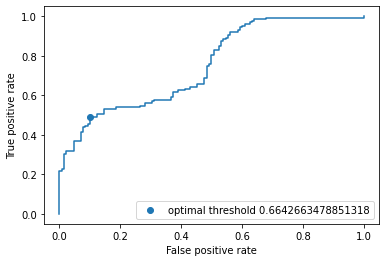

In [11]:
predictions = predict(params_max)
print("Predictions of globally optimised NN:")
for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {predictions[i]}")

fpr, tpr, thresholds = roc_curve(y_true=y[:,0],y_score=predictions, pos_label=1)
metric = jnp.abs(1-tpr) + jnp.abs(fpr)
idx = plt.argmin(metric)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.scatter(fpr[idx], tpr[idx], label=f'optimal threshold {thresholds[idx]}')
plt.legend()
plt.show()

In [12]:
optimal_thresh = thresholds[idx]
classifications = (predictions > optimal_thresh)
accuracy = jnp.mean(classifications == y[:,0])
print(f"accuracy of globally optimised NN with optimal threshold: {accuracy}")

accuracy of globally optimised NN with optimal threshold: 0.69140625


Predictions of BFGS optimised NN:
0: [1. 1. 1. 1. 1. 1. 1. 1.] -> [False] | pred: 3.8984725091800576e-29
1: [1. 1. 1. 1. 1. 1. 1. 0.] -> [ True] | pred: 1.0
2: [1. 1. 1. 1. 1. 1. 0. 1.] -> [ True] | pred: 1.0
3: [1. 1. 1. 1. 1. 1. 0. 0.] -> [False] | pred: 3.081396006646797e-35
4: [1. 1. 1. 1. 1. 0. 1. 1.] -> [ True] | pred: 1.0
5: [1. 1. 1. 1. 1. 0. 1. 0.] -> [False] | pred: 1.7352566990698475e-37
6: [1. 1. 1. 1. 1. 0. 0. 1.] -> [False] | pred: 0.003779980354011059
7: [1. 1. 1. 1. 1. 0. 0. 0.] -> [ True] | pred: 1.0
8: [1. 1. 1. 1. 0. 1. 1. 1.] -> [ True] | pred: 1.0
9: [1. 1. 1. 1. 0. 1. 1. 0.] -> [False] | pred: 9.240174325960717e-29
10: [1. 1. 1. 1. 0. 1. 0. 1.] -> [False] | pred: 0.012543987482786179
11: [1. 1. 1. 1. 0. 1. 0. 0.] -> [ True] | pred: 1.0
12: [1. 1. 1. 1. 0. 0. 1. 1.] -> [False] | pred: 0.0030413377098739147
13: [1. 1. 1. 1. 0. 0. 1. 0.] -> [ True] | pred: 1.0
14: [1. 1. 1. 1. 0. 0. 0. 1.] -> [ True] | pred: 0.999984860420227
15: [1. 1. 1. 1. 0. 0. 0. 0.] -> [False] 

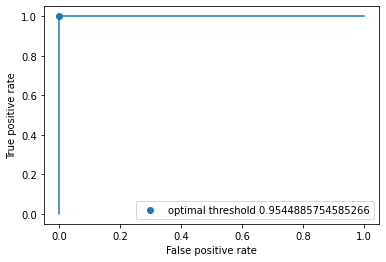

In [13]:
predictions = predict(params_bfgs_max)
print("Predictions of BFGS optimised NN:")
for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {predictions[i]}")

fpr, tpr, thresholds = roc_curve(y_true=y[:,0],y_score=predictions, pos_label=1)
metric = jnp.abs(1-tpr) + jnp.abs(fpr)
idx = plt.argmin(metric)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.scatter(fpr[idx], tpr[idx], label=f'optimal threshold {thresholds[idx]}')
plt.legend()
plt.show()

In [14]:
optimal_thresh = thresholds[idx]
classifications = (predictions > optimal_thresh)
accuracy = jnp.mean(classifications == y[:,0])
print(f"accuracy of BFGS optimised NN with optimal threshold: {accuracy}")

accuracy of BFGS optimised NN with optimal threshold: 0.99609375
